# Importing Data

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
import matplotlib.pyplot as plt

In [4]:
stats_cnx = sql.connect('../../Data/Combined Clean Historical Data/Stats_with_names_1999_2020.db')
stats = pd.read_sql_query('SELECT * FROM Stats_with_names_1999_2020 ', stats_cnx)
stats_cnx.close()
stats['season'] = pd.to_datetime(stats['season'], format='%Y')
stats_prep = stats.copy()

In [45]:
stats_prep['season'] = pd.to_datetime(stats_prep['season'], format='%Y')
stats_prep['nfanpts'] = stats_prep.groupby(['Name','player_id']).shift(-1)['fantasy_points']
stats_prep = stats_prep[stats_prep['nfanpts'].notna()]
stats_prep = stats_prep[stats_prep['Position'].isin(['QB', 'RB', 'WR', 'TE'])]
# This is to take the players who record more then 5 fantasy points in a season.
stats_prep = stats_prep[stats_prep['nfanpts'] >= 5]
stats_prep

,Name,Position,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,...,wopr,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh,nfanpts
0,Charlie Batch,QB,865,1999-01-01,REG,149,267,1908.0,13,7.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163819,148.66
1,Charlie Batch,QB,865,2000-01-01,REG,219,407,2469.0,13,14.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146480,118.18
3,Charlie Batch,QB,865,2003-01-01,REG,4,8,47.0,0,0.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007053,20.84
4,Charlie Batch,QB,865,2005-01-01,REG,23,36,246.0,1,1.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087015,38.28
5,Charlie Batch,QB,865,2006-01-01,REG,30,52,477.0,5,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062492,10.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,Miles Boykin,WR,35703,2019-01-01,REG,0,0,0.0,0,0.0,...,0.183818,0.073442,0.103448,0.072993,0.078313,0.088445,0.079443,0.578947,0.040574,69.60
6404,Drew Lock,QB,35704,2019-01-01,REG,100,156,1020.0,7,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184162,181.32
6406,Daniel Jones,QB,35710,2019-01-01,REG,284,459,3027.0,24,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184513,180.02
6408,Deebo Samuel,WR,35719,2019-01-01,REG,0,0,0.0,0,0.0,...,0.408294,0.206808,0.107143,0.171123,0.162791,0.156975,0.186875,1.754923,0.129103,80.70


In [46]:
stats_prep.rename(columns = {'nfanpts':'target'}, inplace = True)

In [47]:
position_stats = stats_prep.copy()

qb_stats = position_stats[position_stats['Position'].isin(['QB'])]
wr_stats = position_stats[position_stats['Position'].isin(['WR'])]
rb_stats = position_stats[position_stats['Position'].isin(['RB'])]
te_stats = position_stats[position_stats['Position'].isin(['TE'])]

In [48]:
# unwanted_col = ['Name', 'Position', 'player_id','fantast_pts','rushing_epa', 
#            'receiving_2pt_conversions', 'special_teams_tds', 'rushing_2pt_conversions',
#            'rushing_fumbles_lost']

unwanted_col = ['Name', 'Position', 'player_id','season_type','fantasy_points','ppr_sh']

stats_prep.drop(unwanted_col, axis=1, inplace=True)
qb_stats.drop(unwanted_col, axis=1, inplace=True)
wr_stats.drop(unwanted_col, axis=1, inplace=True)
rb_stats.drop(unwanted_col, axis=1, inplace=True)
te_stats.drop(unwanted_col, axis=1, inplace=True)
predictors = list(stats_prep)
unwanted_predictor = {'season', 'target'}
predictors = [e for e in predictors if e not in unwanted_predictor]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
# Trying with non-normazlied data
#
# stats_prep[predictors] = (stats_prep[predictors]-stats_prep[predictors].min())/(stats_prep[predictors].max()-stats_prep[predictors].min())
# stats_prep.describe()

In [50]:
stats_prep.fillna(stats_prep.mean(), inplace= True)
qb_stats.fillna(qb_stats.mean(), inplace= True)
wr_stats.fillna(wr_stats.mean(), inplace= True)
rb_stats.fillna(rb_stats.mean(), inplace= True)
te_stats.fillna(te_stats.mean(), inplace= True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a fu

In [51]:
stats_prep = stats_prep.set_index(['season'])
stats_prep = stats_prep.sort_index()

qb_stats = qb_stats.set_index(['season'])
qb_stats = qb_stats.sort_index()

wr_stats = wr_stats.set_index(['season'])
wr_stats = wr_stats.sort_index()

rb_stats = rb_stats.set_index(['season'])
rb_stats = rb_stats.sort_index()

te_stats = te_stats.set_index(['season'])
te_stats = te_stats.sort_index()

## Adding aDOT (an advanced stat) to data

In [52]:
stats_prep['aDOT'] = stats_prep['receiving_air_yards'] / stats_prep['targets']
stats_prep['aDOT'] = stats_prep['aDOT'].fillna(0)

In [53]:
qb_stats['aDOT'] = qb_stats['receiving_air_yards'] / qb_stats['targets']
qb_stats['aDOT'] = qb_stats['aDOT'].fillna(0)

wr_stats['aDOT'] = wr_stats['receiving_air_yards'] / wr_stats['targets']
wr_stats['aDOT'] = wr_stats['aDOT'].fillna(0)

rb_stats['aDOT'] = rb_stats['receiving_air_yards'] / rb_stats['targets']
rb_stats['aDOT'] = rb_stats['aDOT'].fillna(0)

te_stats['aDOT'] = te_stats['receiving_air_yards'] / te_stats['targets']
te_stats['aDOT'] = te_stats['aDOT'].fillna(0)

## Adding Rushing Advanced Stats

In [54]:
stats_prep['r_att_gm'] = stats_prep['carries'] / stats_prep['games']
stats_prep['r_att_gm'] = stats_prep['r_att_gm'].fillna(0)

qb_stats['r_att_gm'] = qb_stats['carries'] / qb_stats['games']
qb_stats['r_att_gm'] = qb_stats['r_att_gm'].fillna(0)

wr_stats['r_att_gm'] = wr_stats['carries'] / wr_stats['games']
wr_stats['r_att_gm'] = wr_stats['r_att_gm'].fillna(0)

rb_stats['r_att_gm'] = rb_stats['carries'] / rb_stats['games']
rb_stats['r_att_gm'] = rb_stats['r_att_gm'].fillna(0)

te_stats['r_att_gm'] = te_stats['carries'] / te_stats['games']
te_stats['r_att_gm'] = te_stats['r_att_gm'].fillna(0)

In [55]:
stats_prep['r_yds_cry'] = stats_prep['rushing_yards'] / stats_prep['carries']
stats_prep['r_yds_cry'] = stats_prep['r_yds_cry'].fillna(0)

qb_stats['r_yds_cry'] = qb_stats['rushing_yards'] / qb_stats['carries']
qb_stats['r_yds_cry'] = qb_stats['r_yds_cry'].fillna(0)

wr_stats['r_yds_cry'] = wr_stats['rushing_yards'] / wr_stats['carries']
wr_stats['r_yds_cry'] = wr_stats['r_yds_cry'].fillna(0)

rb_stats['r_yds_cry'] = rb_stats['rushing_yards'] / rb_stats['carries']
rb_stats['r_yds_cry'] = rb_stats['r_yds_cry'].fillna(0)

te_stats['r_yds_cry'] = te_stats['rushing_yards'] / te_stats['carries']
te_stats['r_yds_cry'] = te_stats['r_yds_cry'].fillna(0)

# Tree Stuff

In [ ]:
X = stats_prep[predictors].values
y = stats_prep['target'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

print(X_train.shape); print(X_test.shape)

In [ ]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [ ]:
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

75.18280003715206
0.27405689336092987


In [ ]:
pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))

77.35182555880763
0.24324158778800975


In [ ]:
dtree1 = DecisionTreeRegressor(max_depth=2)
dtree2 = DecisionTreeRegressor(max_depth=5)
dtree1.fit(X_train, y_train)
dtree2.fit(X_train, y_train)
tr1 = dtree1.predict(X_train)
tr2 = dtree2.predict(X_train)
y1 = dtree1.predict(X_test)
y2 = dtree2.predict(X_test) 

In [ ]:
print(np.sqrt(mean_squared_error(y_train,tr1))) 
print(r2_score(y_train, tr1))
print(np.sqrt(mean_squared_error(y_test,y1))) 
print(r2_score(y_test, y1)) 

75.67033265245784
0.2646114227403925
76.56133155040659
0.25862988092854744


In [ ]:
#RF model

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))
pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

24.19433280142664
0.9248216319675299
65.80461840420469
0.4523174905121248


# Tree Prediction

In [ ]:
stats_cnx = sql.connect('/content/drive/MyDrive/Colab Notebooks/Open-Sports-Data-NFL-main/Data/Yearly Data as Database/Stats_with_names_2021.db')
stats_2021 = pd.read_sql_query('SELECT * FROM Stats_with_names_2021 ', stats_cnx)
stats_cnx.close()

In [ ]:
stats_2021 = stats_2021[stats_2021['Position'].isin(['QB', 'RB', 'WR', 'TE'])]

In [ ]:
stats_2021['wopr'] = stats_2021['wopr_x'] + stats_2021['wopr_y']

In [ ]:
stats_2021['rtd_sh'] = stats_2021['rtd_sh'].fillna(stats_2021['rtd_sh'].mean())
stats_2021['dom'] = stats_2021['dom'].fillna(stats_2021['dom'].mean())
stats_2021['w8dom'] = stats_2021['w8dom'].fillna(stats_2021['w8dom'].mean())

In [ ]:
#Trying with non-normalized data

#stats_2021[predictors] = (stats_2021[predictors]-stats_2021[predictors].min())/(stats_2021[predictors].max()-stats_2021[predictors].min())

In [ ]:
pred_test = model_rf.predict(stats_2021[predictors])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
stats_2021['rob_fpts_2022'] = pred_test

In [ ]:
cols = list(stats_2021)
cols.insert(2, cols.pop(cols.index('rob_fpts_2022')))
stats_2021 = stats_2021.loc[:, cols]
stats_2021['rob_fpts_2022'] = stats_2021['rob_fpts_2022'].apply(lambda x: round(x, 2))
stats_2021

,Name,Position,rob_fpts_2022,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,...,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,wopr
0,Tom Brady,QB,251.44,19596,2021,REG,485,719,5316.0,43,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Ben Roethlisberger,QB,197.24,22924,2021,REG,390,605,3740.0,22,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Aaron Rodgers,QB,254.11,23459,2021,REG,366,531,4115.0,37,...,0.000000,0.001939,-0.000923,0.000000,0.000000,0.000000,-0.000461,-0.000738,-0.007156,0.042417
4,Ryan Fitzpatrick,QB,33.82,23682,2021,REG,3,6,13.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Marcedes Lewis,TE,92.82,24243,2021,REG,0,0,0.0,0,...,0.078560,0.115650,0.064497,0.000000,0.057803,0.050000,0.032248,0.051597,0.467249,1.666035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,Hunter Long,TE,45.14,37004,2021,REG,0,0,0.0,0,...,0.015625,0.047322,0.010076,0.000000,0.000000,0.000000,0.005038,0.008060,0.068966,0.197952
640,Tommy Tremble,TE,87.52,37005,2021,REG,0,0,0.0,0,...,0.048985,0.165644,0.063003,0.090909,0.074627,0.075862,0.076956,0.068584,0.360000,2.579061
641,Tre' McKitty,TE,70.64,37011,2021,REG,0,0,0.0,0,...,0.036836,0.054752,0.023974,0.000000,0.030303,0.026786,0.011987,0.019180,0.177165,0.433019
642,Trey Lance,QB,95.67,37012,2021,REG,41,71,603.0,5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
predicted_fpts_2022 = stats_2021.filter(['Name','Position','rob_fpts_2022'], axis=1)

In [ ]:
predicted_fpts_2022.sort_values(by=['rob_fpts_2022'], ascending=False)

,Name,Position,rob_fpts_2022
531,Justin Jefferson,WR,323.76
94,Davante Adams,WR,305.11
188,Dak Prescott,QB,274.17
14,Matthew Stafford,QB,273.63
46,Kirk Cousins,QB,266.35
...,...,...,...
471,Nathan Cottrell,RB,27.23
287,Trenton Cannon,RB,26.47
98,Garrett Gilbert,QB,25.76
277,Nathan Peterman,QB,23.82


In [ ]:
top50 = predicted_fpts_2022.nlargest(50,'rob_fpts_2022')
top50['Position'].value_counts()

QB    20
WR    19
RB     8
TE     3
Name: Position, dtype: int64

In [ ]:
# Norm. output
#
# WR    21
# QB    21
# RB     6
# TE     2

# XG Boost 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib.pyplot import figure

In [ ]:
stats_prep['wopr'] = 100*stats_prep['wopr']

In [ ]:
#X, y = stats_prep.iloc[:,:-1],stats_prep.iloc[:,-1]
X,y = stats_prep.drop("target", axis=1), stats_prep["target"]

In [ ]:
X.columns

Index(['completions', 'attempts', 'passing_yards', 'passing_tds',
       'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions',
       'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'special_teams_tds', 'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr',
       'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'dom', 'w8dom', 'yptmpa',
       'aDOT', 'r_att_gm', 'r_yds_cry'],
      dtype='object')

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 500, n_estimators = 1000)

In [ ]:
# Takes a while to run on Colab

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(xg_reg, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

In [ ]:
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

71.6526388995133

In [ ]:
print(r2_score(y_test, preds))

0.3575767301855557


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
params = { 'max_depth': np.arange(100,1000,100),
           'learning_rate': np.arange(0.2,0.5,0.05),
           'colsample_bytree': np.arange(0.2, 1.0, 0.1),
           'n_estimators': np.arange(100, 1500, 100),
          'colsample_bylevel': [0.3,0.4,0.5,0.6,0.7,0.8]}

          
# Takes near 40mins to run. Don't run unless needed. 
#
# with tf.device(device_name):
#     xgbr = xgb.XGBRegressor(objective ='reg:squarederror', seed = 100)
#     clf = RandomizedSearchCV(estimator=xgbr,
#                          param_distributions=params,
#                          scoring='neg_mean_squared_error',
#                          n_iter=100,
#                          verbose=1)
#     clf.fit(X, y)

In [ ]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", np.sqrt((-clf.best_score_)))

Best parameters: {'n_estimators': 600, 'max_depth': 700, 'learning_rate': 0.2, 'colsample_bytree': 0.5000000000000001, 'colsample_bylevel': 0.3}
Lowest RMSE:  72.46331154191556


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 400, n_estimators = 1200, colsample_bylevel = 0.4)

# Optimized from Best Params
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.2,
#                 max_depth = 700, n_estimators = 600, colsample_bylevel = 0.3)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f' The RMSE: {rmse}\n R2 Value: {r2}')

 The RMSE: 70.44714689427713
 R2 Value: 0.3790112935917186


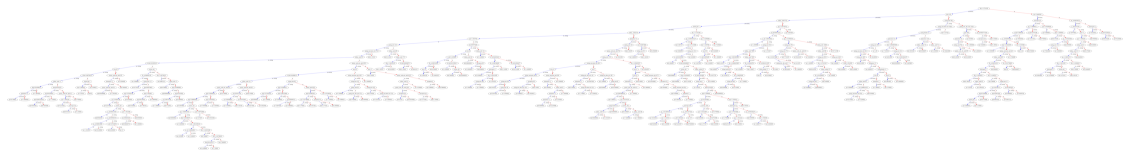

In [ ]:
fig = xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [18,16]
plt.show()

In [ ]:
import graphviz
xgb_tree = xgb.to_graphviz(xg_reg, num_trees=0, rankdir='LR')

#Set a different dpi (work only if format == 'png')
xgb_tree.graph_attr = {'dpi':'600'}

xgb_tree.render('xgb__non_Normal_output', format = 'png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.164192 to fit


'xgb__non_Normal_output.png'

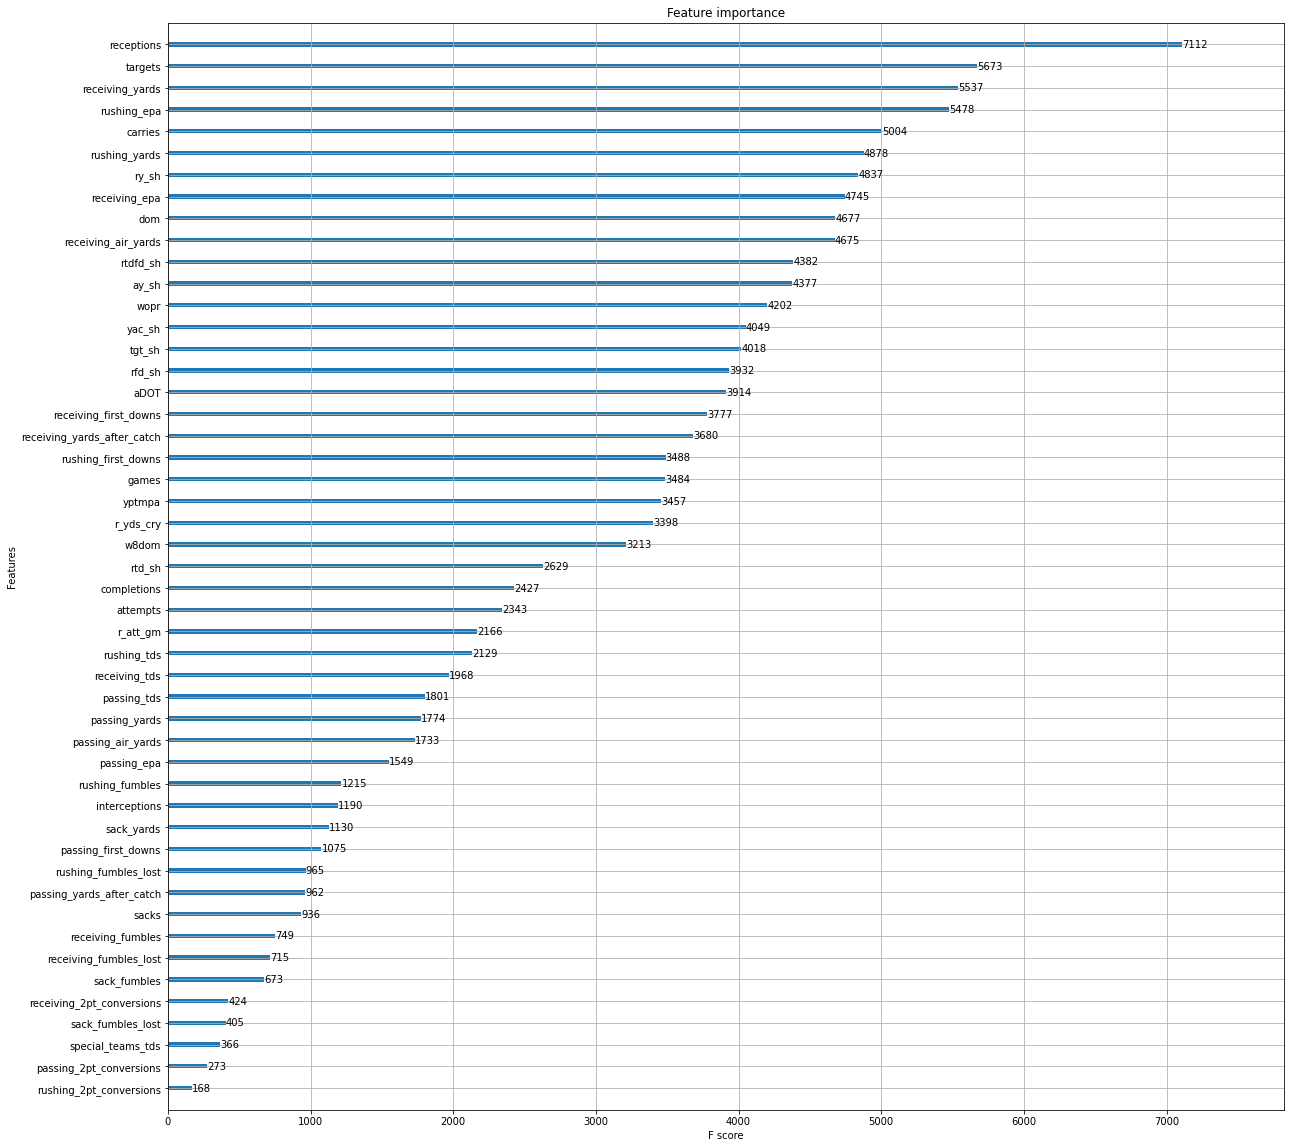

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20,20]
plt.show()

# XGB Positional Model

In [56]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib.pyplot import figure

In [57]:
qb_stats['wopr'] = 100*qb_stats['wopr']
wr_stats['wopr'] = 100*wr_stats['wopr']
rb_stats['wopr'] = 100*rb_stats['wopr']
te_stats['wopr'] = 100*te_stats['wopr']

In [58]:
#X, y = stats_prep.iloc[:,:-1],stats_prep.iloc[:,-1]
Xq,yq = qb_stats.drop("target", axis=1), qb_stats["target"]

Xw,yw = wr_stats.drop("target", axis=1), wr_stats["target"]

Xr,yr = rb_stats.drop("target", axis=1), rb_stats["target"]

Xt,yt = te_stats.drop("target", axis=1), te_stats["target"]

In [59]:
qb_data_dmatrix = xgb.DMatrix(data=Xq,label=yq)

wr_data_dmatrix = xgb.DMatrix(data=Xw,label=yw)

rb_data_dmatrix = xgb.DMatrix(data=Xr,label=yr)

te_data_dmatrix = xgb.DMatrix(data=Xt,label=yt)

In [60]:
Xq_train, Xq_test, yq_train, yq_test = train_test_split(Xq, yq, test_size=0.3, random_state=100)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=0.3, random_state=100)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=100)

Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.3, random_state=100)


In [61]:
qb_xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 500, n_estimators = 1000)

wr_xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 500, n_estimators = 1000)

rb_xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 500, n_estimators = 1000)

te_xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.2, learning_rate = 0.2,
                max_depth = 500, n_estimators = 1000)

In [62]:
qb_xg_reg.fit(Xq_train,yq_train)
qb_preds = qb_xg_reg.predict(Xq_test)

wr_xg_reg.fit(Xw_train,yw_train)
wr_preds = wr_xg_reg.predict(Xw_test)

rb_xg_reg.fit(Xr_train,yr_train)
rb_preds = rb_xg_reg.predict(Xr_test)

te_xg_reg.fit(Xt_train,yt_train)
te_preds = te_xg_reg.predict(Xt_test)

In [66]:
qb_rmse = np.sqrt(mean_squared_error(yq_test, qb_preds))
wr_rmse = np.sqrt(mean_squared_error(yw_test, wr_preds))
rb_rmse = np.sqrt(mean_squared_error(yr_test, rb_preds))
te_rmse = np.sqrt(mean_squared_error(yt_test, te_preds))

print(f'''QB RMSE: {qb_rmse}
WR RMSE: {wr_rmse}
RB RMSE: {rb_rmse} 
TE RMSE: {te_rmse}''')

QB RMSE: 85.49696670775866
WR RMSE: 67.97974825981225
RB RMSE: 71.72895038961619 
TE RMSE: 52.91306729503274


In [67]:
qb_r2 = r2_score(yq_test, qb_preds)
wr_r2 = r2_score(yw_test, wr_preds)
rb_r2 = r2_score(yr_test, rb_preds)
te_r2 = r2_score(yt_test, te_preds)
print(f'''QB R-Square: {qb_r2}
WR R-Square: {wr_r2}
RB R-Square: {rb_r2} 
TE R-Square: {te_r2}
''')

QB R-Square: 0.3501922322346046
WR R-Square: 0.27481085021686624
RB R-Square: 0.24055686143124844 
TE R-Square: 0.3832179753513154



# XGB Predicition

In [ ]:
stats_cnx = sql.connect('/content/drive/MyDrive/Colab Notebooks/Open-Sports-Data-NFL-main/Data/Yearly Data as Database/Stats_with_names_2021.db')
stats_2021 = pd.read_sql_query('SELECT * FROM Stats_with_names_2021 ', stats_cnx)
stats_cnx.close()

In [ ]:
stats_2021['aDOT'] = stats_2021['receiving_air_yards'] / stats_2021['targets']

In [ ]:
stats_2021['aDOT'] = stats_2021['aDOT'].fillna(0)

In [ ]:
stats_2021['r_att_gm'] = stats_2021['carries'] / stats_2021['games']
stats_2021['r_att_gm'] = stats_2021['r_att_gm'].fillna(0)
stats_2021['r_yds_cry'] = stats_2021['rushing_yards'] / stats_2021['carries']
stats_2021['r_yds_cry'] = stats_2021['r_yds_cry'].fillna(0)

In [ ]:
stats_2021 = stats_2021[stats_2021['Position'].isin(['QB', 'RB', 'WR', 'TE'])]

In [ ]:
stats_2021['wopr'] = stats_2021['tgt_sh'] * 1.5 + stats_2021['ay_sh'] * 0.7

In [ ]:
predictors = X.columns

In [ ]:
xg_pred_test = xg_reg.predict(stats_2021[predictors])

In [ ]:
stats_2021['rob_fpts_2022'] = xg_pred_test

In [ ]:
cols = list(stats_2021)
cols.insert(2, cols.pop(cols.index('rob_fpts_2022')))
stats_2021 = stats_2021.loc[:, cols]
stats_2021['rob_fpts_2022'] = stats_2021['rob_fpts_2022'].apply(lambda x: round(x, 2))
stats_2021

,Name,Position,rob_fpts_2022,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,...,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,aDOT,r_att_gm,r_yds_cry,wopr
0,Tom Brady,QB,250.65,19596,2021,REG,485,719,5316.0,43,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647059,2.892857,0.000000
2,Ben Roethlisberger,QB,237.82,22924,2021,REG,390,605,3740.0,22,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.250000,0.000000
3,Aaron Rodgers,QB,204.05,23459,2021,REG,366,531,4115.0,37,...,0.000000,0.000000,0.000000,-0.000461,-0.000738,-0.007156,-4.000000,2.062500,3.060606,0.002032
4,Ryan Fitzpatrick,QB,33.49,23682,2021,REG,3,6,13.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
5,Marcedes Lewis,TE,57.53,24243,2021,REG,0,0,0.0,0,...,0.000000,0.057803,0.050000,0.032248,0.051597,0.467249,3.678571,0.000000,0.000000,0.112656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,Hunter Long,TE,62.90,37004,2021,REG,0,0,0.0,0,...,0.000000,0.000000,0.000000,0.005038,0.008060,0.068966,3.333333,0.000000,0.000000,0.046256
640,Tommy Tremble,TE,44.18,37005,2021,REG,0,0,0.0,0,...,0.090909,0.074627,0.075862,0.076956,0.068584,0.360000,8.200000,0.214286,3.666667,0.158064
641,Tre' McKitty,TE,33.26,37011,2021,REG,0,0,0.0,0,...,0.000000,0.030303,0.026786,0.011987,0.019180,0.177165,2.250000,0.000000,0.000000,0.053813
642,Trey Lance,QB,86.99,37012,2021,REG,41,71,603.0,5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.333333,4.421053,0.000000


In [ ]:
predicted_fpts_2022 = stats_2021.filter(['Name','Position','rob_fpts_2022'], axis=1)

In [ ]:
predicted_fpts_2022.sort_values(by=['rob_fpts_2022'], ascending=False)

,Name,Position,rob_fpts_2022
547,Jalen Hurts,QB,273.34
87,Derek Carr,QB,264.65
94,Davante Adams,WR,264.11
14,Matthew Stafford,QB,263.69
50,Ryan Tannehill,QB,262.89
...,...,...,...
481,Jonathan Ward,RB,21.48
568,Kenny Yeboah,TE,20.43
595,Adam Prentice,RB,20.11
218,Patrick Ricard,RB,18.10


In [ ]:
top50 = predicted_fpts_2022.nlargest(50,'rob_fpts_2022')
top50['Position'].value_counts()

QB    23
WR    14
RB    11
TE     2
Name: Position, dtype: int64

In [ ]:
# 2010-2020 Dataset Output
#
# QB    24
# RB    12
# WR    11
# TE     3

In [ ]:
# Using sub-optimal parameters of 
# colsample_bytree = 0.2, learning_rate = 0.2,max_depth = 500, n_estimators = 1000
#
# QB    21
# WR    14
# RB    12
# TE     3

In [ ]:
# Without adding aDOT (just stats loaded in from NFL-Py)
# QB    22
# WR    14
# RB    11
# TE     3

In [ ]:
# Adding aDOT 
# QB    21
# WR    15
# RB    11
# TE     3

In [ ]:
# Added Rushing Advanced Stats, keeping low F-scores and EPA
# QB    23
# WR    14
# RB    11
# TE     2

In [ ]:
top50 = top50.reset_index(drop=True)
top50.index += 1 
top50.index.rename('2022 Rank',inplace=True)
top50

,Name,Position,rob_fpts_2022
2022 Rank,,,
1,Jalen Hurts,QB,273.34
2,Derek Carr,QB,264.65
3,Davante Adams,WR,264.11
4,Matthew Stafford,QB,263.69
5,Ryan Tannehill,QB,262.89
6,Dak Prescott,QB,255.34
7,Tom Brady,QB,250.65
8,Josh Allen,QB,248.58
9,Justin Herbert,QB,245.79


# XBG Position Prediction

In [68]:
stats_cnx = sql.connect('/content/drive/MyDrive/Colab Notebooks/Open-Sports-Data-NFL-main/Data/Yearly Data as Database/Stats_with_names_2021.db')
stats_2021 = pd.read_sql_query('SELECT * FROM Stats_with_names_2021 ', stats_cnx)
stats_cnx.close()

In [69]:
stats_2021['aDOT'] = stats_2021['receiving_air_yards'] / stats_2021['targets']

In [70]:
stats_2021['aDOT'] = stats_2021['aDOT'].fillna(0)

In [71]:
stats_2021['r_att_gm'] = stats_2021['carries'] / stats_2021['games']
stats_2021['r_att_gm'] = stats_2021['r_att_gm'].fillna(0)
stats_2021['r_yds_cry'] = stats_2021['rushing_yards'] / stats_2021['carries']
stats_2021['r_yds_cry'] = stats_2021['r_yds_cry'].fillna(0)

In [72]:
stats_2021['wopr'] = stats_2021['tgt_sh'] * 1.5 + stats_2021['ay_sh'] * 0.7

In [73]:
qb_stats_2021 = stats_2021[stats_2021['Position'].isin(['QB'])]
wr_stats_2021 = stats_2021[stats_2021['Position'].isin(['WR'])]
rb_stats_2021 = stats_2021[stats_2021['Position'].isin(['RB'])]
te_stats_2021 = stats_2021[stats_2021['Position'].isin(['TE'])]

In [74]:
predictors = Xq.columns

In [75]:
qb_xg_pred_test = qb_xg_reg.predict(qb_stats_2021[predictors])
wr_xg_pred_test = wr_xg_reg.predict(wr_stats_2021[predictors])
rb_xg_pred_test = rb_xg_reg.predict(rb_stats_2021[predictors])
te_xg_pred_test = te_xg_reg.predict(te_stats_2021[predictors])

In [76]:
qb_stats_2021['rob_fpts_2022'] = qb_xg_pred_test
wr_stats_2021['rob_fpts_2022'] = wr_xg_pred_test
rb_stats_2021['rob_fpts_2022'] = rb_xg_pred_test
te_stats_2021['rob_fpts_2022'] = te_xg_pred_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [79]:
combined_pred = pd.concat([qb_stats_2021,wr_stats_2021,rb_stats_2021,te_stats_2021])

In [80]:
cols = list(combined_pred)
cols.insert(2, cols.pop(cols.index('rob_fpts_2022')))
combined_pred = combined_pred.loc[:, cols]
combined_pred['rob_fpts_2022'] = combined_pred['rob_fpts_2022'].apply(lambda x: round(x, 2))
combined_pred

,Name,Position,rob_fpts_2022,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,...,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,aDOT,r_att_gm,r_yds_cry,wopr
0,Tom Brady,QB,283.72,19596,2021,REG,485,719,5316.0,43,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647059,2.892857,0.000000
2,Ben Roethlisberger,QB,223.76,22924,2021,REG,390,605,3740.0,22,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.250000,0.250000,0.000000
3,Aaron Rodgers,QB,251.78,23459,2021,REG,366,531,4115.0,37,...,0.000000,0.000000,0.000000,-0.000461,-0.000738,-0.007156,-4.000000,2.062500,3.060606,0.002032
4,Ryan Fitzpatrick,QB,24.85,23682,2021,REG,3,6,13.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
9,Matt Ryan,QB,221.91,26143,2021,REG,375,560,3968.0,20,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.352941,2.050000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,Pat Freiermuth,TE,80.35,36894,2021,REG,0,0,0.0,0,...,0.318182,0.178010,0.192488,0.224092,0.167638,0.800322,5.291139,0.000000,0.000000,0.260405
628,Kyle Pitts,TE,114.83,36970,2021,REG,0,0,0.0,0,...,0.050000,0.219388,0.203704,0.153668,0.215869,1.790576,10.800000,0.000000,0.000000,0.488731
639,Hunter Long,TE,37.80,37004,2021,REG,0,0,0.0,0,...,0.000000,0.000000,0.000000,0.005038,0.008060,0.068966,3.333333,0.000000,0.000000,0.046256
640,Tommy Tremble,TE,63.61,37005,2021,REG,0,0,0.0,0,...,0.090909,0.074627,0.075862,0.076956,0.068584,0.360000,8.200000,0.214286,3.666667,0.158064


In [81]:
predicted_fpts_2022 = combined_pred.filter(['Name','Position','rob_fpts_2022'], axis=1)

In [82]:
predicted_fpts_2022.sort_values(by=['rob_fpts_2022'], ascending=False)

,Name,Position,rob_fpts_2022
396,Kyler Murray,QB,308.43
630,Mac Jones,QB,295.62
0,Tom Brady,QB,283.72
50,Ryan Tannehill,QB,282.90
46,Kirk Cousins,QB,277.23
...,...,...,...
214,Cethan Carter,TE,17.69
559,Stephen Sullivan,TE,16.35
403,Trevon Wesco,TE,16.18
479,Darius Bradwell,RB,15.23


In [83]:
top50 = predicted_fpts_2022.nlargest(50,'rob_fpts_2022')
top50['Position'].value_counts()

QB    22
WR    21
RB     7
Name: Position, dtype: int64

# 2020 Verification

In [ ]:
stats_19 = stats.copy()

In [ ]:
stats_19 = stats_19[stats_19['season'].dt.year == 2019]

In [ ]:
stats_19['aDOT'] = stats_19['receiving_air_yards'] / stats_19['targets']
stats_19['aDOT'] = stats_19['aDOT'].fillna(0)
stats_19['r_att_gm'] = stats_19['carries'] / stats_19['games']
stats_19['r_att_gm'] = stats_19['r_att_gm'].fillna(0)
stats_19['r_yds_cry'] = stats_19['rushing_yards'] / stats_19['carries']
stats_19['r_yds_cry'] = stats_19['r_yds_cry'].fillna(0)
stats_19 = stats_19[stats_19['Position'].isin(['QB', 'RB', 'WR', 'TE'])]
stats_19['wopr'] = stats_19['tgt_sh'] * 1.5 + stats_19['ay_sh'] * 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
predictors = X.columns
xg_pred_test = xg_reg.predict(stats_19[predictors])
stats_19['rob_fpts_2020'] = xg_pred_test

In [ ]:
cols = list(stats_19)
cols.insert(2, cols.pop(cols.index('rob_fpts_2020')))
stats_19 = stats_19.loc[:, cols]
stats_19['rob_fpts_2020'] = stats_19['rob_fpts_2020'].apply(lambda x: round(x, 2))
stats_19

,Name,Position,rob_fpts_2020,player_id,season,season_type,completions,attempts,passing_yards,passing_tds,...,rtd_sh,rfd_sh,rtdfd_sh,dom,w8dom,yptmpa,ppr_sh,aDOT,r_att_gm,r_yds_cry
159,Tom Brady,QB,337.92,19596,2019-01-01,REG,373,613,4057.0,24,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179165,0.000000,1.625000,1.307692
311,Drew Brees,QB,209.48,20531,2019-01-01,REG,281,378,2979.0,27,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190652,0.000000,0.818182,-0.444444
412,Josh McCown,QB,89.09,21206,2019-01-01,REG,3,5,24.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004985,0.000000,1.000000,-1.000000
607,Jason Witten,TE,50.81,22127,2019-01-01,REG,0,0,0.0,0,...,0.133333,0.117904,0.119691,0.120624,0.112999,0.886097,0.083894,6.578313,0.000000,0.000000
736,Matt Schaub,QB,111.21,22787,2019-01-01,REG,50,67,580.0,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067992,0.000000,0.600000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,Miles Boykin,WR,68.54,35703,2019-01-01,REG,0,0,0.0,0,...,0.103448,0.072993,0.078313,0.088445,0.079443,0.578947,0.040574,17.181818,0.000000,0.000000
6404,Drew Lock,QB,15.14,35704,2019-01-01,REG,100,156,1020.0,7,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184162,0.000000,3.600000,4.000000
6406,Daniel Jones,QB,199.36,35710,2019-01-01,REG,284,459,3027.0,24,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184513,0.000000,3.461538,6.200000
6408,Deebo Samuel,WR,139.69,35719,2019-01-01,REG,0,0,0.0,0,...,0.107143,0.171123,0.162791,0.156975,0.186875,1.754923,0.129103,7.382716,0.933333,11.357143


In [ ]:
predicted_fpts_2020 = stats_19.filter(['Name','Position','rob_fpts_2020'], axis=1)
predicted_fpts_2020.sort_values(by=['rob_fpts_2020'], ascending=False)

,Name,Position,rob_fpts_2020
6205,Josh Allen,QB,396.06
976,Aaron Rodgers,QB,383.26
6278,Kyler Murray,QB,378.74
5660,Deshaun Watson,QB,368.68
3501,Russell Wilson,QB,359.78
...,...,...,...
3156,Anthony Sherman,RB,13.93
6297,Jarrett Stidham,QB,12.94
3866,Zach Line,RB,10.66
4587,Diontae Spencer,WR,8.50


In [ ]:
top50_pred_20 = predicted_fpts_2020.nlargest(50,'rob_fpts_2020')
pred_dist = top50_pred_20['Position'].value_counts()

In [ ]:
top50_pred_20 = top50_pred_20.reset_index(drop=True)
top50_pred_20.index += 1 
top50_pred_20['2020 Predicted Rank'] = top50_pred_20.index

In [ ]:
top50_pred_20

,Name,Position,rob_fpts_2020,2020 Predicted Rank
1,Josh Allen,QB,396.06,1
2,Aaron Rodgers,QB,383.26,2
3,Kyler Murray,QB,378.74,3
4,Deshaun Watson,QB,368.68,4
5,Russell Wilson,QB,359.78,5
6,Ryan Tannehill,QB,348.36,6
7,Tom Brady,QB,337.92,7
8,Lamar Jackson,QB,332.78,8
9,Alvin Kamara,RB,330.54,9
10,Dalvin Cook,RB,322.09,10


In [ ]:
stats20 = stats.copy()

In [ ]:
stats20 = stats20[stats20['season'].dt.year == 2020]

In [ ]:
stats20['aDOT'] = stats20['receiving_air_yards'] / stats20['targets']
stats20['aDOT'] = stats20['aDOT'].fillna(0)
stats20['r_att_gm'] = stats20['carries'] / stats20['games']
stats20['r_att_gm'] = stats20['r_att_gm'].fillna(0)
stats20['r_yds_cry'] = stats20['rushing_yards'] / stats20['carries']
stats20['r_yds_cry'] = stats20['r_yds_cry'].fillna(0)
stats20 = stats20[stats20['Position'].isin(['QB', 'RB', 'WR', 'TE'])]
stats20['wopr'] = stats20['tgt_sh'] * 1.5 + stats20['ay_sh'] * 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
actual_fpts_2020 = stats20.filter(['Name','Position','fantasy_points'], axis=1)
actual_fpts_2020.sort_values(by=['fantasy_points'], ascending=False)

,Name,Position,fantasy_points
6206,Josh Allen,QB,396.06
977,Aaron Rodgers,QB,383.26
6279,Kyler Murray,QB,378.74
5834,Alvin Kamara,RB,377.80
5795,Patrick Mahomes,QB,374.40
...,...,...,...
6303,Easton Stick,QB,-0.04
737,Matt Schaub,QB,-0.40
5930,Tim Boyle,QB,-0.90
5337,Nate Sudfeld,QB,-1.52


In [ ]:
top50_act_20 = actual_fpts_2020.nlargest(50,'fantasy_points')
act_dist = top50_act_20['Position'].value_counts()

In [ ]:
top50_act_20 = top50_act_20.reset_index(drop=True)
top50_act_20.index += 1 
top50_act_20['2020 Actual Rank'] = top50_act_20.index

In [ ]:
top50_act_20

,Name,Position,fantasy_points,2020 Actual Rank
1,Josh Allen,QB,396.06,1
2,Aaron Rodgers,QB,383.26,2
3,Kyler Murray,QB,378.74,3
4,Alvin Kamara,RB,377.80,4
5,Patrick Mahomes,QB,374.40,5
6,Deshaun Watson,QB,369.32,6
7,Russell Wilson,QB,359.78,7
8,Davante Adams,WR,358.40,8
9,Ryan Tannehill,QB,348.36,9
10,Tom Brady,QB,337.92,10


In [ ]:
print(f'Actual distribution is: \n{act_dist}\n Predicted distribution is: \n{pred_dist} ')

Actual distribution is: 
QB    20
WR    20
RB     8
TE     2
Name: Position, dtype: int64
 Predicted distribution is: 
QB    21
WR    16
RB    11
TE     2
Name: Position, dtype: int64 


In [ ]:
pred_act = top50_pred_20.merge(top50_act_20.drop(['Position'], axis=1), on="Name")

In [ ]:
pred_act['Rank Difference'] = pred_act['2020 Predicted Rank'] - pred_act['2020 Actual Rank']
pred_act['Pts Difference'] = pred_act['rob_fpts_2020'] - pred_act['fantasy_points']

In [ ]:
diff_pred_act = pred_act.filter(['Name','Rank Difference','Pts Difference'], axis=1)
diff_pred_act['Pts Difference'] = diff_pred_act['Pts Difference'].round(2)
diff_pred_act

,Name,Rank Difference,Pts Difference
0,Josh Allen,0,0.00
1,Aaron Rodgers,0,0.00
2,Kyler Murray,0,0.00
3,Deshaun Watson,-2,-0.64
4,Russell Wilson,-2,-0.00
5,Ryan Tannehill,-3,0.00
6,Tom Brady,-3,0.00
7,Lamar Jackson,-6,-0.00
8,Alvin Kamara,5,-47.26
9,Dalvin Cook,-1,-15.71


In [ ]:
diff_pred_act.describe()

,Rank Difference,Pts Difference
count,37.000000,37.000000
mean,-0.756757,-23.244595
std,10.067565,34.051401
min,-27.000000,-158.850000
25%,-5.000000,-31.400000
50%,-1.000000,-17.450000
75%,3.000000,0.000000
max,37.000000,38.400000
